# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

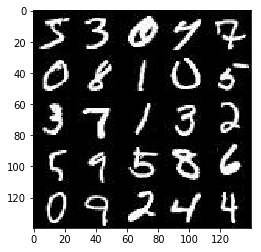

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

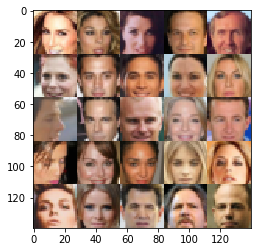

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    ##############################################################
    # Notifications:
    #  all hyper parameters and activation function are set
    #  according to the DCGAN paper
    ##############################################################
    
    # I always use discriminator as a trainer for the generator 
    is_training = True
        
    # (from the paper)
    # >> In the LeakyReLU, the slope of the leak was set to 0.2 in all models
    alpha = 0.2
        
    # (from the paper)
    # >> All weights were initialized from a zero-centered Normal distribution
    # >> with standard deviation 0.02
    d_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # CONV layer w/o batch normalization and LeakyReLU
        # 28x28 to 14x14x64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', use_bias=False, kernel_initializer=d_initializer)
        x1 = tf.nn.leaky_relu(x1, alpha=alpha)
        
        # CONV layer w/ batch normalization and LeakyReLU
        # 14x14x64 to 7x7x128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', use_bias=False, kernel_initializer=d_initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_training)
        x2 = tf.nn.leaky_relu(x2, alpha=alpha)
        
        # CONV layer w/ batch normalization and LeakyReLU
        # 7x7x128 to 3x3x256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', use_bias=False, kernel_initializer=d_initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_training)
        x3 = tf.nn.leaky_relu(x3, alpha=alpha)
        
        flat = tf.layers.flatten(x3)
        
        # Output layer (Binary classifier)
        logits = tf.layers.dense(flat, 1, use_bias=False, kernel_initializer=d_initializer)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    ##############################################################
    # Notifications:
    #  all hyper parameters are set
    #  according to the DCGAN paper (same as the discriminator)
    #  
    #  In the DCGAN paper, author mentions about the generator like following:
    #  >> Use ReLU activation in generator for all layers 
    #  >> except for the output, which uses Tanh.
    #   
    #  However, I need to actively treat the negative values in this project,
    #  I decided to use the leakyRelu function as a activation function.
    #  
    ##############################################################
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        g_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        
        # Fully-connected layer
        # z shape to (512x4x4)
        x1 = tf.layers.dense(z, 512 * 4 * 4, activation=None, kernel_initializer=g_initializer)
        # Reshape into the convolutional stack
        # (512x4x4) to 4x4x512
        x1 = tf.reshape(x1, shape=[-1, 4, 4, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.leaky_relu(x1, alpha=alpha)
        
        # Transposed CONV layer w/ batch normalization and ReLU
        # 4x4x512 to 7x7x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', 
                                            activation=None, kernel_initializer=g_initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.leaky_relu(x2, alpha=alpha)
        
        # Transposed CONV layer w/ batch normalization and ReLU
        # 7x7x256 to 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                            activation=None, kernel_initializer=g_initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.leaky_relu(x3, alpha=alpha)
        
        # Output layer
        # 14x14x128 to 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                            activation=None, kernel_initializer=g_initializer)
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # One-sided label
    smooth = 0.9
    
    # Generate models
    g_output = generator(input_z, out_channel_dim, is_train=True)
    # Real image discrimination
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    # Fake image discrimination
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)

    # Loss for the discriminater 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real) * smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Loss for the generator 
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get trainable variables and separate into two parts
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Iteration counter
    n_iter = 0
    # Image numbers to monitor
    show_n_images = 25
    # Printing parameters
    print_every = 20
    show_every = 100
    
    # Build the Graph
    input_real, input_z, lr = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                # rescale images into range[-1,1] to fit the tanh output of the generator
                batch_images *= 2
                
                # increment a iteration counter
                n_iter += 1
                
                # Create z data for feeding to the graph
                batch_z = np.random.uniform(low=-1, high=1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, 
                             feed_dict={
                                 input_real: batch_images,
                                 input_z: batch_z, 
                                 lr: learning_rate})                
                _ = sess.run(g_opt, 
                             feed_dict={
                                 input_real: batch_images,
                                 input_z: batch_z, 
                                 lr: learning_rate})                
                
                # Print losses in each 20 iteration
                if n_iter % print_every == 0:
                    train_loss_d = sess.run(d_loss, 
                                            feed_dict={
                                                input_real: batch_images, 
                                                input_z: batch_z,
                                                lr: learning_rate})
                    train_loss_g = sess.run(g_loss,
                                            feed_dict={
                                                input_real: batch_images, 
                                                input_z: batch_z,
                                                lr: learning_rate})
                    print('epoch: {}/{}'.format(epoch_i+1, epoch_count),
                          'iteration: {} ... '.format(n_iter),
                          'd_loss: {:.4f}'.format(train_loss_d), 
                          'g_loss: {:.4f}'.format(train_loss_g))
                    
                # Print the generator output every 100 batches
                if n_iter % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
        
        
        # show result after training
        
        print("\n##### Training finished. Show the generator outputs. #####")
        
        train_loss_d = sess.run(d_loss, 
                                feed_dict={
                                    input_real: batch_images, 
                                    input_z: batch_z,
                                    lr: learning_rate})
        train_loss_g = sess.run(g_loss,
                                feed_dict={
                                    input_real: batch_images, 
                                    input_z: batch_z,
                                    lr: learning_rate})
        
        print('d_loss: {:.4f}'.format(train_loss_d), 
              'g_loss: {:.4f}'.format(train_loss_g))
        
        show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch: 1/2 iteration: 20 ...  d_loss: 0.6497 g_loss: 2.7558
epoch: 1/2 iteration: 40 ...  d_loss: 0.5888 g_loss: 3.4371
epoch: 1/2 iteration: 60 ...  d_loss: 0.5435 g_loss: 1.9787
epoch: 1/2 iteration: 80 ...  d_loss: 0.4277 g_loss: 3.3781
epoch: 1/2 iteration: 100 ...  d_loss: 0.6188 g_loss: 2.1354


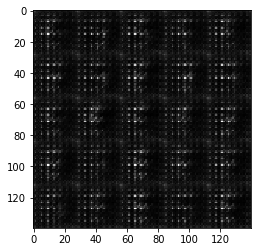

epoch: 1/2 iteration: 120 ...  d_loss: 0.4811 g_loss: 3.4511
epoch: 1/2 iteration: 140 ...  d_loss: 0.6008 g_loss: 2.6262
epoch: 1/2 iteration: 160 ...  d_loss: 0.6569 g_loss: 2.1708
epoch: 1/2 iteration: 180 ...  d_loss: 0.8855 g_loss: 1.0506
epoch: 1/2 iteration: 200 ...  d_loss: 0.8347 g_loss: 2.0028


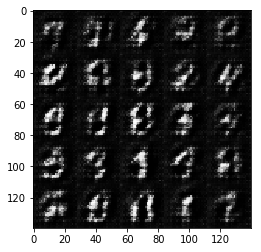

epoch: 1/2 iteration: 220 ...  d_loss: 1.0907 g_loss: 1.8587
epoch: 1/2 iteration: 240 ...  d_loss: 0.9661 g_loss: 1.6600
epoch: 1/2 iteration: 260 ...  d_loss: 0.9691 g_loss: 1.2351
epoch: 1/2 iteration: 280 ...  d_loss: 0.8466 g_loss: 2.2555
epoch: 1/2 iteration: 300 ...  d_loss: 0.6685 g_loss: 1.6965


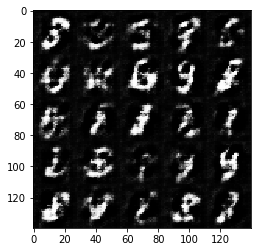

epoch: 1/2 iteration: 320 ...  d_loss: 1.0141 g_loss: 2.6364
epoch: 1/2 iteration: 340 ...  d_loss: 0.8208 g_loss: 1.7672
epoch: 1/2 iteration: 360 ...  d_loss: 0.8471 g_loss: 1.7129
epoch: 1/2 iteration: 380 ...  d_loss: 0.8231 g_loss: 1.9618
epoch: 1/2 iteration: 400 ...  d_loss: 0.7465 g_loss: 1.4537


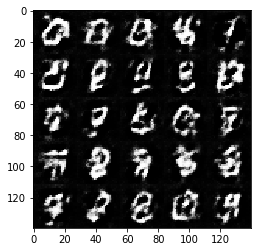

epoch: 1/2 iteration: 420 ...  d_loss: 0.9709 g_loss: 0.8778
epoch: 1/2 iteration: 440 ...  d_loss: 0.7188 g_loss: 2.0259
epoch: 1/2 iteration: 460 ...  d_loss: 0.7229 g_loss: 1.5932
epoch: 2/2 iteration: 480 ...  d_loss: 0.7332 g_loss: 1.6647
epoch: 2/2 iteration: 500 ...  d_loss: 0.8524 g_loss: 1.2557


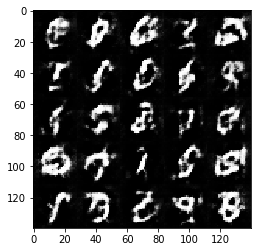

epoch: 2/2 iteration: 520 ...  d_loss: 0.9478 g_loss: 1.0109
epoch: 2/2 iteration: 540 ...  d_loss: 1.1782 g_loss: 0.7105
epoch: 2/2 iteration: 560 ...  d_loss: 0.7077 g_loss: 1.7528
epoch: 2/2 iteration: 580 ...  d_loss: 0.9891 g_loss: 2.5307
epoch: 2/2 iteration: 600 ...  d_loss: 0.9418 g_loss: 0.9041


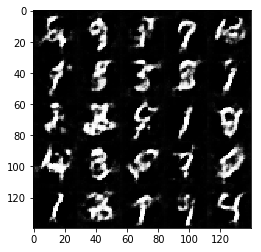

epoch: 2/2 iteration: 620 ...  d_loss: 0.8837 g_loss: 1.0135
epoch: 2/2 iteration: 640 ...  d_loss: 0.7180 g_loss: 1.5571
epoch: 2/2 iteration: 660 ...  d_loss: 0.8467 g_loss: 1.5531
epoch: 2/2 iteration: 680 ...  d_loss: 0.8982 g_loss: 1.6597
epoch: 2/2 iteration: 700 ...  d_loss: 0.8789 g_loss: 1.1811


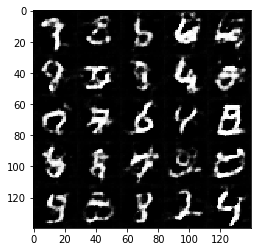

epoch: 2/2 iteration: 720 ...  d_loss: 0.8135 g_loss: 1.7910
epoch: 2/2 iteration: 740 ...  d_loss: 0.8845 g_loss: 2.2692
epoch: 2/2 iteration: 760 ...  d_loss: 0.8558 g_loss: 2.4086
epoch: 2/2 iteration: 780 ...  d_loss: 0.9139 g_loss: 1.7543
epoch: 2/2 iteration: 800 ...  d_loss: 0.7877 g_loss: 1.6536


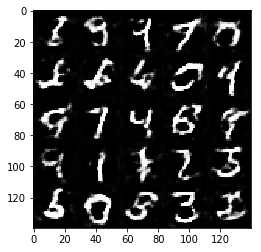

epoch: 2/2 iteration: 820 ...  d_loss: 0.8180 g_loss: 1.7867
epoch: 2/2 iteration: 840 ...  d_loss: 0.7785 g_loss: 1.2869
epoch: 2/2 iteration: 860 ...  d_loss: 1.0684 g_loss: 0.7409
epoch: 2/2 iteration: 880 ...  d_loss: 1.0199 g_loss: 2.7077
epoch: 2/2 iteration: 900 ...  d_loss: 1.1373 g_loss: 2.4939


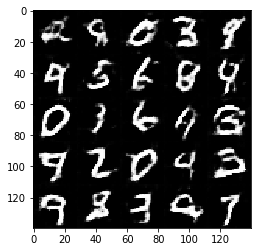

epoch: 2/2 iteration: 920 ...  d_loss: 0.8386 g_loss: 1.3159

##### Training finished. Show the generator outputs. #####
d_loss: 0.7782 g_loss: 1.4688


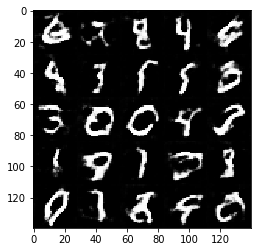

In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = None
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.